# TEST SET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
from keras.layers import (Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, Add, Concatenate, ZeroPadding2D, add, Dropout, Conv2DTranspose, Lambda, multiply, 
GlobalAveragePooling2D, Dense, Reshape)
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.losses import binary_crossentropy
import keras.backend as K
import cv2
import rasterio
import json

In [ ]:
pip install keras-unet-collection

     |████████████████████████████████| 71kB 4.4MB/s 


In [ ]:
pip install rasterio

     |████████████████████████████████| 19.3MB 1.3MB/s 


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Image size that we are going to use
IMG_SIZE = 128
# Our images are RGB (3 channels)
N_CHANNELS = 3

SEED = 42

dataset_path = "/content/drive/MyDrive/training/"
training_data = "images/"
masks = "masks/"

In [ ]:
TRAINSET_SIZE = len(glob.glob(dataset_path + training_data + "*.png"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")

The Training Dataset contains 4488 images.


In [ ]:
MASKSET_SIZE = len(glob.glob(dataset_path + masks + "*.png"))
print(f"The MASk Dataset contains {MASKSET_SIZE} images.")

The MASk Dataset contains 4500 images.


In [ ]:
VAL_PERCENT = 20

VALSET_SIZE = TRAINSET_SIZE * VAL_PERCENT // 100

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask = tf.cast(input_mask, tf.float32) / 255.0
  return input_image, input_mask


@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

  if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask


@tf.function
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask


def parse_image(img_path: str) -> dict:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    mask_path = tf.strings.regex_replace(img_path, "images", "masks")
    mask = tf.io.read_file(mask_path)
    
    # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)

    return {'image': image, 'segmentation_mask': mask}

In [ ]:
dataset = tf.data.Dataset.list_files(dataset_path + training_data + "*.png", seed=SEED)
dataset = dataset.map(parse_image)

test_dataset = dataset.take(VALSET_SIZE)
train_dataset = dataset.skip(VALSET_SIZE)

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask = tf.cast(input_mask, tf.float32) / 255.0
  return input_image, input_mask

@tf.function
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask


def parse_image(img_path: str) -> dict:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    mask_path = tf.strings.regex_replace(img_path, "images", "masks")
    mask = tf.io.read_file(mask_path)
    
    # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)

    return {'image': image, 'segmentation_mask': mask}

In [ ]:
BATCH_SIZE = 1
BUFFER_SIZE = 1

dataset = {"train": None, "test": None}

def load_dataset(batch_size=BATCH_SIZE):
  # -- Train Dataset --#
  dataset = {"train": train_dataset, "test": test_dataset}
  dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
  dataset['train'] = dataset['train'].repeat()
  dataset['train'] = dataset['train'].batch(batch_size)
  dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

  #-- Validation Dataset --#
  dataset['test'] = dataset['test'].map(load_image_test)
  # dataset['test'] = dataset['test'].repeat()
  dataset['test'] = dataset['test'].batch(batch_size)
  dataset['test'] = dataset['test'].prefetch(buffer_size=AUTOTUNE)
  
  return dataset

In [ ]:
dataset = load_dataset()

In [ ]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    return K.mean((2. * intersection + smooth)/(union + smooth))


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + (1 - dice_coef(y_true, y_pred))

In [ ]:
def summarize_diagnostics(history, name):
  fig = plt.figure(figsize=(8,10))
  plt.subplot(211)
  plt.title('loss')
  lines = []
  lines += plt.plot(history.history['loss'], color='blue', label='train')
  lines += plt.plot(history.history['dice_coef'], color='green', label='train')
  lines += plt.plot(history.history['val_loss'], color='orange', label='test')
  lines += plt.plot(history.history['val_dice_coef'], color='red', label='test')
  plt.legend(lines, ['loss', 'dice_coef', 'val_loss', 'val_dice_coef'])
#   plt.savefig(f'test_part/plots/{name}')
  plt.show()

In [ ]:
from keras_unet_collection import models

In [ ]:
model = models.r2_unet_2d((None, None, 3), [64, 128, 256, 512], n_labels=1,
                          stack_num_down=2, stack_num_up=1, recur_num=2,
                          activation='ReLU', output_activation='Sigmoid', 
                          batch_norm=True, pool='max', unpool='nearest', name='r2unet')

In [ ]:
def evaluate(model, activation_func, name):
    model.load_weights(f'{dataset_path}/weights_from_promo/best_weights_r2unet_relu.hdf5')
    model.compile(optimizer=RMSprop(lr=0.001), loss=bce_dice_loss, metrics=[dice_coef])
    # try:
    # model.evaluate(dataset['test'], verbose=1)
    # except Exception as e:
    #     print(e)
    
    try:
        show_prediction(model, f'{name}_{activation_func}')
    except Exception as e:
        print(e)

In [ ]:
evaluate(model, 'relu', 'r2unet')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## TIFFS

In [ ]:
TEST_HOME = f'{dataset_path}/test/'
HOME = dataset_path
CURR_DIR = f'/{dataset_path}/working/'
VAL_DIR = f'/{dataset_path}/working/validation'
import os

In [ ]:

# masks_files = [os.path.basename(f) for f in glob.glob(TRAIN_HOME + "*.json") if "anatomical" not in f]

image_test_files = [os.path.basename(f) for f in glob.glob(TEST_HOME + "*.tiff")]
data_info = pd.read_csv(os.path.join(HOME, "HuBMAP-20-dataset_information.csv"))


In [ ]:
def id_from_filename(image_file):
    return image_file.split('.')[0]


def open_tiff_file(image_file, base_path=TEST_HOME):
    with rasterio.open(base_path + image_file) as file:
        if file.count == 3:
            image = file.read([1, 2, 3]).transpose(1, 2, 0).copy()
        else:
            h, w = (file.height, file.width)
            subdatasets = file.subdatasets
            if len(subdatasets) > 0:
                image = np.zeros((h, w, len(subdatasets)), dtype=np.uint8)
                for i, subdataset in enumerate(subdatasets, 0):
                    with rasterio.open(subdataset) as layer:
                        image[:, :, i] = layer.read(1)
    return image


In [ ]:
def make_grid(shape, window=1024, min_overlap=0):
    y, x = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx, ny, 4), dtype=np.int64)

    for i in range(nx):
        for j in range(ny):
            slices[i, j] = x1[i], x2[i], y1[j], y2[j]
    return slices.reshape(nx * ny, 4)


def get_tile(image, mask, x, y, tile_size, scale=1.0):
    x = round(x * scale)
    y = round(y * scale)
    image_s = image[y:y + tile_size, x:x + tile_size, :]
    mask_s = mask[y:y + tile_size, x:x + tile_size, :]
    return image_s, mask_s

In [ ]:
def create_mask(inference, threshold=0.5):
    pred_mask = np.squeeze(inference, axis=3)
    prob = np.array(cv2.resize(pred_mask[0], (256, 256)))
    prob = np.where(prob > threshold, 1, 0)
    pred_mask = tf.expand_dims(prob, axis=-1)
    return np.array(pred_mask)

def add_to_mask(image, mask, coordinates, scale = 1.0): 
    x, y, tile_size = coordinates 
    mask_x, mask_y, _ = mask.shape
    mask = cv2.resize(np.uint8(mask[:,:,0]), (tile_size, tile_size), interpolation = cv2.INTER_AREA) 
    new_arr = np.logical_or(mask, image[y:y + tile_size, x:x + tile_size]) 
    image[y:y + tile_size, x:x + tile_size] = new_arr
    del mask

In [ ]:
def display_samples(samples, predicted = False):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    if predicted:
      title = ['Input Image', 'True Mask', 'Predicted Mask']
    else:
      title = ['Input Image', 'True Mask']

    index = 1

    for display_list in samples:
      for j in range(len(display_list)):
        plt.subplot(len(samples), len(title), index)
        index += 1
        plt.title(title[j])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[j]))
        plt.axis('off')
    plt.show()
    

In [ ]:
def generate_masked_image(img_file, model, scale=1.0):
    file_id = id_from_filename(img_file)
    img_json = None
    with open(f'{VAL_DIR}/{file_id}.json', 'r') as file:
        img_json = json.load(file)
    size = img_json['tiff_w'], img_json['tiff_h']
    image_votes = np.zeros((size[0], size[1]), dtype=np.uint8)

    images = get_images_of_tiff(file_id)
    for img_name in images:
        img = load_val_img(img_name)
        mask = create_mask(model.predict(img)) # mask ma 256,256
        add_to_mask(image_votes, mask, img_json['samples'][img_name.split('.')[0]], scale=scale)
        del img, mask
        
    return image_votes

In [ ]:
def get_images_of_tiff(image):
    image_files = [os.path.basename(f) for f in glob.glob(VAL_DIR+ "/images/" + image + "*.png")]
    return image_files

In [ ]:
def predict_tiff(image, model, scale=1.0):
    masked_image = generate_masked_image(image, model, scale=scale)
    plt.imshow(masked_image)
    file_id = id_from_filename(image)
    image_to_rle(masked_image, file_id)

In [ ]:
def predict_validation():
    for tiff in image_test_files:
        predict_tiff(tiff, model, scale=4)

In [ ]:
def get_tile_img(image, x, y, tile_size):
    image_s = image[y:y + tile_size, x:x + tile_size, :]
    return image_s

def generate_test_samples(img_file, path, window=1024, scale=1):
    file_id = id_from_filename(img_file)
    image = open_tiff_file(img_file, TEST_HOME)
    size = image.shape

    samples_dict = {
        'tiff_w': int(size[0]),
        'tiff_h': int(size[1]),
        'samples': {}
    }

    boxes = make_grid((size[0], size[1]), window=window)
    saved = 0
    for i, box in enumerate(boxes):
        x, y = box[0], box[2]
        image_s = get_tile_img(image, x, y, window)
        image_s = cv2.resize(image_s, (image_s.shape[1] // scale, image_s.shape[0] // scale))
        cv2.imwrite(f'{path}/images/{file_id}_{saved:03}.png', cv2.cvtColor(image_s, cv2.COLOR_RGB2BGR))
        samples_dict['samples'][f'{file_id}_{saved:03}'] = (int(x), int(y), window)
        saved += 1
        del image_s
    print(f'saved {saved}')
    with open(f'{VAL_DIR}/{file_id}.json', 'w+') as out:
        out.write(json.dumps(samples_dict))
    del image
    print('saved json and delete img')
    
def generate_val_samples_json(img_file, window=1024, scale=1.0):
    size = (data_info[data_info['image_file'] == img_file].iloc[0]['width_pixels'],
            data_info[data_info['image_file'] == img_file].iloc[0]['height_pixels'])
    samples_dict = {
        'tiff_w': int(size[0]),
        'tiff_h': int(size[1]),
        'samples': {}
    }

    boxes = make_grid((size[0], size[1]), window=window)
    file_id = id_from_filename(img_file)
    saved = 0
    for i, box in enumerate(boxes):
        x, y = box[0], box[2]
        samples_dict['samples'][f'{file_id}_{saved:03}'] = (int(x), int(y), window)
        saved += 1
    print(os.getcwd())
    with open(f'{VAL_DIR}/{file_id}.json', 'w+') as out:
        out.write(json.dumps(samples_dict))

In [ ]:
img_file=image_test_files[0]

generate_test_samples(img_file, VAL_DIR, window=1024, scale=4)


/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


saved 1457
saved json and delete img


In [ ]:
samples = [(img, mask)]

In [ ]:
def load_val_img(img_name):
  image = tf.io.read_file(VAL_DIR + '/images/' + img_name)
  image = tf.image.decode_png(image, channels=3)
  input_image = tf.cast(image, tf.float32) / 255.0
  input_image = tf.image.resize(input_image, (128, 128))
  input_image1 = input_image[tf.newaxis, ...]
  return input_image1


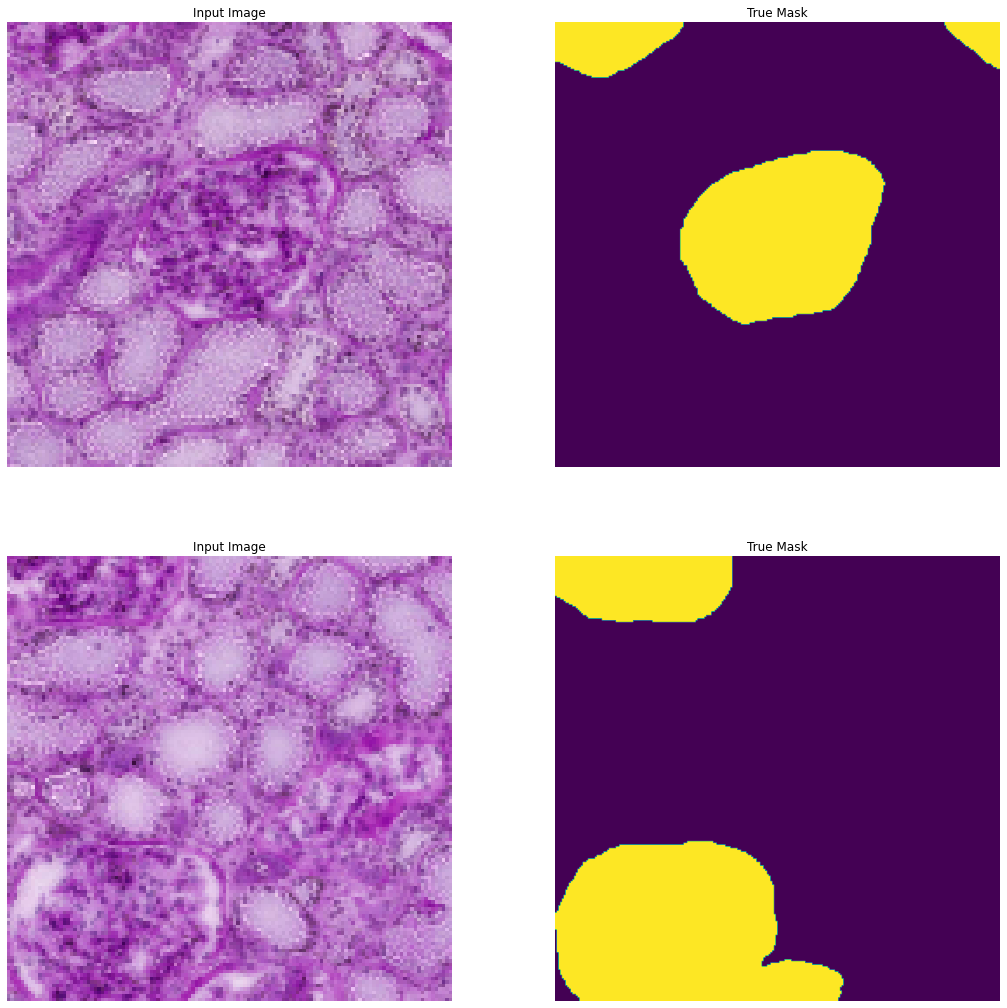

In [ ]:
img_name = 'aa05346ff_854.png'
input_image1 = load_val_img(img_name)
predict = model.predict(input_image1)
mask = create_mask(predict, threshold=0.5) 
samples.append((input_image1[0], mask))
display_samples(samples)
# print(mask)

In [ ]:
image = 'aa05346ff.tiff'
masked_image = generate_masked_image(image, model, scale=4)

In [ ]:
def rle_encode_less_memory(img):
    #watch out for the bug
    pixels = img.T.flatten()
    
    # This simplified method requires first and last pixel to be zero
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

In [ ]:
rle = rle_encode_less_memory(masked_image)

In [ ]:
masked_image[masked_image>1]

array([], dtype=uint8)

In [ ]:
with open(f'{CURR_DIR}aa05346ff.txt', 'w+') as out:
        out.write(rle)

In [ ]:
del masked_image

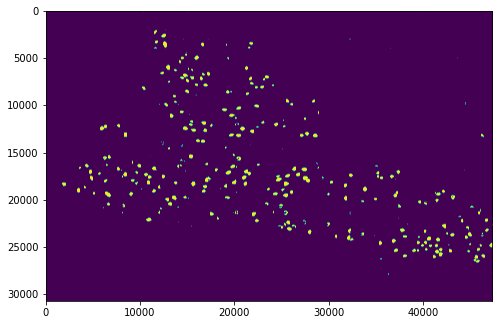

In [ ]:
plt.figure(figsize=(8,8))
# plt.imshow(masked_image[20000:25000, 20000:25000])
plt.imshow(masked_image)

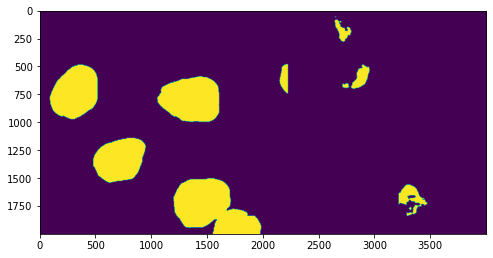

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(masked_image[16000:18000, 26000:30000])